In [1]:
import os
os.environ['RPPREFIX'] = r'C:/Program Files (x86)/REFPROP'
import mat_properties as prop
import numpy as n
import pandas as pd
import time

start_time = time.time()
#-------------input

RP = prop.init_REFPROP(r'C:\Program Files (x86)\REFPROP')

#номинальные параметры
P0_nom = 7.845
T_00_nom = 508.6
P_par_nd_nom = 0.549
T_par_nd_nom =197.8
P_otb2_nom = 0.2542
T_otb2_nom = 131.4
P_CND_nom = 0.1525
T00_CND_nom = 111.8
P_otb1_nom = P_CND_nom
T_otb1_nom = T00_CND_nom
P_K_nom = 0.008
G0_nom = 63.4
G_nd_nom = 14.76

#режимные параметры Конд 50% -40
P0 = 5.199
T0 = 492.2
G0 = 41.97
P_par_nd = 0.36
T_par_nd = 191.9
G_nd = 12.88

P_otb2 = 0.15
P_otb1 = 0.0647
P_CND = 0.0647
P_K=0.0048

KPDdrosCVD = 1
KPDdrosCND = 1.3

KPDoiCVD = 0.9
KPDoiCND = 0.9

print('P0',P0,'P_par_nd',P_par_nd,'P_otb2',P_otb2,'P_otb1',P_otb1,'P_CND',P_CND,'P_K',P_K)
#---------------------------------------Часть Максима

water=prop.Materials_prop('water',[1.0,0,0,0,0], prop.REFPROP_h_s,
                                              prop.REFPROP_p_t,
                                              prop.REFPROP_p_h,
                                              prop.REFPROP_p_s,
                                              prop.REFPROP_p_q,
                                              prop.REFPROP_t_q,
                                              RP=RP)
# print(water.p_q(0.1525,0)['T'])
class turbine:
    def __init__(self,water,P0,T0,P_par_nd,T_par_nd,P_otb1,P_otb2,P_CND,P_K, 
                 KPDdrosCVD,KPDdrosCND,KPDoiCVD,KPDoiCND,
                G0,G_nd,P0_nom,P_par_nd_nom,P_otb2_nom,P_otb1_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom):
        
        #- для расчета Теплоперепадов    
        self.water = water
        
        #- То что получаю ОТ КОТЛА
        self.__P0 = P0
        self.__T0 = T0
        self.__P_par_nd = P_par_nd
        self.__T_par_nd = T_par_nd
        #- Давления в отборах

        self.__P_otb1 = P_otb1
        self.__P_otb2 = P_otb2
        self.__P_CND = P_CND

        #- Постоянные значения
        self.__P_K = P_K
        self.__KPDdrosCVD=KPDdrosCVD
        self.__KPDdrosCND=KPDdrosCND
        self.__KPDoiCVD=KPDoiCVD
        self.__KPDoiCND=KPDoiCND
        #- для расчета режимов

        #- То что получаю ОТ КОТЛА
        self.__G0 = G0
        self.__G_nd = G_nd

        #- Постоянные значения (номинальные)
        self.__P0_nom = P0_nom
        self.__P_par_nd_nom = P_par_nd_nom
        self.__P_otb2_nom = P_otb2_nom
        self.__P_otb1_nom = P_CND_nom
        self.__P_CND_nom = P_CND_nom
        self.__G0_nom = G0_nom
        self.__G_nd_nom = G_nd_nom
        self.__P_K_nom = P_K_nom
    
    
    def calc_teplo(self):
        #---- Расчет параметров от входа высокого давления до отсека входа низкого давления
        
        h0   = self.water.p_t(self.__P0,self.__T0)['h']
        S0  = self.water.p_t(self.__P0,self.__T0)['s']
        P00 = self.__KPDdrosCVD * self.__P0 # -ТУТ ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ ТЕПЛОФИКАЦИЮ
        S00   = self.water.p_h(P00,h0)['s']
        T00   = self.water.p_h(P00,h0)['T']
                        #---- Расчет параметров НД на входе в турбину
        h_par_nd =self.water.p_t(self.__P_par_nd,self.__T_par_nd)['h']
        s_par_nd =self.water.p_t(self.__P_par_nd,self.__T_par_nd)['s']
                #---- Расчет параметров второго отбора
        h_teor_otb2 = self.water.p_s(self.__P_otb2,S00)['h'] 
        h_otb2 = h0-(h0-h_teor_otb2)*self.__KPDoiCVD# -ТУТ ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ изменение 
                                                         #относительного КПД от режима нагрузки
        T_otb2 = water.p_h(self.__P_otb2,h_otb2)['T']
        S_otb2  = self.water.p_h(P_otb2,h_otb2)['s']
        h_teor_otb1 = self.water.p_s(self.__P_otb1,S_otb2)['h']
        h_otb1 = h_otb2-(h_otb2-h_teor_otb1)*self.__KPDoiCVD # -ТУТ ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ Изменение 
                                                             #относительного КПД от режима нагрузки
        S_otb1 = self.water.p_h(self.__P_otb1,h_otb1)['s']
        T_otb1 = water.p_h(self.__P_otb1,h_otb1)['T']
        #---- Расчет параметров цилиндра низкого давления которые равны параметрам в отборе 1 .Выходит так, 
         #что отбор 1 стоит на выходе из ЦВД и перед входом в ЦНД. Но ответы не будут совпадать с таблицей по ЦНД,
        h_CND= h_otb1
        S_CND = S_otb1
        T_CND = T_otb1
        P00_CND = self.__KPDdrosCND * self.__P_otb1 # -ТУТ ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ ТЕПЛОФИКАЦИЮ
        S00_CND = self.water.p_h(P00_CND,h_CND)['s']
        T00_CND = self.water.p_h(P00_CND,h_CND)['T']
        h_teor_K = self.water.p_s(self.__P_K,S00_CND)['h']
        h_K = h_CND-(h_CND-h_teor_K)*self.__KPDoiCND# -ТУТ ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ Изменение 
                                                                #относительного КПД от режима нагрузки
        S_K = self.water.p_h(self.__P_K,h_K)['s']
        T_K = water.p_h(self.__P_K,h_K)['T']
        #---- Расчет теплоперепадов
        H0_nd = h0 - h_par_nd
        Hnd_otb2= h_par_nd - h_otb2
        Hotb2_otb1 = h_otb2 - h_otb1
        Hcnd_k = h_CND - h_K
        #---- Вывод результатов
        res = dict()
        res['P0'] = self.__P0
        res['h0'] = h0
        res['s0'] = S0
        res['P00'] = P00
        res['S00'] = S00
        res['T00'] = T00
        res['P_par_nd'] = P_par_nd
        res['h_par_nd'] = h_par_nd
        res['s_par_nd'] = s_par_nd
        res['h_otb2'] = h_otb2
        res['T_otb2'] = T_otb2
        res['S_otb2'] = S_otb2
        res['P_otb2'] = self.__P_otb2
        res['h_otb1'] = h_otb1
        res['S_otb1'] = S_otb1
        res['T_otb1'] = T_otb1
        res['P_otb1'] = self.__P_otb1
        res['P_CND'] = self.__P_CND
        res['h_CND'] = h_CND
        res['S_CND'] = S_CND
        res['T_CND'] = T_CND
        res['P00_CND'] = P00_CND
        res['S00_CND'] = S00_CND
        res['T00_CND'] = T00_CND
        res['h_K'] = h_K
        res['S_K'] = S_K
        res['T_K'] = T_K
        res['P_K'] = self.__P_K
        
        return res
    
    def calc_rejim_init(self):
        #Уравнения СТОДОЛЫ-ФЛЮГЕЛЯ
        P00_CND = (((((self.__G0+self.__G_nd)/(self.__G0_nom+self.__G_nd_nom))**2)*
                 (self.__P_CND_nom**2-self.__P_K_nom**2)+self.__P_K**2)**0.5)#нет поправки на температуру
        P_CND = P00_CND / self.__KPDdrosCND #self.__KPDdrosCND -ТУТ ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ ТЕПЛОФИКАЦИЮ
        P_otb1 = P_CND
        P00_otb2 = (((((self.__G0+self.__G_nd)/(self.__G0_nom+self.__G_nd_nom))**2)*
                 (self.__P_otb2_nom**2-self.__P_otb1_nom**2)+P_otb1**2)**0.5)#нет поправки на температуру
        P_otb2 = P00_otb2 / self.__KPDdrosCND #self.__KPDdrosCND -ТУТ ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ ТЕПЛОФИКАЦИЮ
        P_par_nd = (((((self.__G0+self.__G_nd)/(self.__G0_nom+self.__G_nd_nom))**2)*
                 (self.__P_par_nd_nom**2-self.__P_otb2_nom**2)+P_otb2**2)**0.5)#нет поправки на температуру
        P00 =((((self.__G0/self.__G0_nom)**2)*
                 (self.__P0_nom**2-self.__P_par_nd_nom**2)+P_par_nd**2)**0.5)#нет поправки на температуру
        P0 = P00 / self.__KPDdrosCVD
#---- Вывод результатов
        res=dict()
        res['P0']=P0
        res['P_par_nd']=P_par_nd
        res['P_otb2']=P_otb2
        res['P_otb1']=P_otb1
        res['P_CND']=P_CND
        res['P_K']=P_K
        return res
    
    
    def calc_rejim(self,T00_CND,T00_CND_nom,T_otb2,T_otb2_nom,T_par_nd,T_par_nd_nom,T_00,T_00_nom):
        #Уравнения СТОДОЛЫ-ФЛЮГЕЛЯ    
        P00_CND = (((((self.__G0+self.__G_nd)/(self.__G0_nom+self.__G_nd_nom))**2)*
                 ((self.__P_CND_nom**2-self.__P_K_nom**2)*((T00_CND+273.15)/(T00_CND_nom+273.15)))+
                    self.__P_K**2)**0.5)# Необходимо учесть утечки
        P_CND = P00_CND / self.__KPDdrosCND 
        P_otb1 = P_CND
        
        P00_otb2 = (((((self.__G0+self.__G_nd)/(self.__G0_nom+self.__G_nd_nom))**2)*
                 ((self.__P_otb2_nom**2-self.__P_otb1_nom**2)*((T_otb2+273.15)/(T_otb2_nom+273.15)))+P_otb1**2)**0.5)
        P_otb2 = P00_otb2 / self.__KPDdrosCND # Необходимо учесть утечки +- ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ ТЕПЛОФИКАЦИЮ
        P_par_nd = ((((self.__G0+self.__G_nd)/(self.__G0_nom+self.__G_nd_nom))**2)*
                 ((self.__P_par_nd_nom**2-self.__P_otb2_nom**2*((T_par_nd+273.15)/(T_par_nd_nom+273.15)))+P_otb2**2)**0.5)
        P00 = ((((self.__G0/self.__G0_nom)**2)*
                    (self.__P0_nom**2-self.__P_par_nd_nom**2*((T_00+273.15)/(T_00_nom+273.15)))+P_par_nd**2)**0.5) 
        P0 = P00 / self.__KPDdrosCVD # Необходимо учесть утечки +- ДОЛЖНА БЫТЬ ФУНКЦИЯ УЧИТЫВАЮЩАЯ ТЕПЛОФИКАЦИЮ
#---- Вывод результатов
        res=dict()
        res['P0']=P0
        res['P_par_nd'] = P_par_nd
        res['P_otb2']=P_otb2
        res['P_otb1']=P_otb1
        res['P_CND']=P_CND
        res['P_K']=P_K
        return res

        

# print('P0',teplo['P0'],'P_par_nd',teplo['P_par_nd'],'P_otb2',teplo['P_otb2'],'P_otb1',teplo['P_otb1'],'P_CND',teplo['P_CND'],'Эталон')

rejim=turbine(water,P0,T0,P_par_nd,T_par_nd,P_otb1,P_otb2,P_CND,P_K, 
                 KPDdrosCVD,KPDdrosCND,KPDoiCVD,KPDoiCND,
                G0,G_nd,P0_nom,P_par_nd_nom,P_otb2_nom,P_otb1_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom).calc_rejim_init()

# print(rejim,'1 прогон')

# test = rejim['P0']
P0=rejim['P0']
P_par_nd=rejim['P_par_nd']
P_otb2=rejim['P_otb2']
P_otb1=rejim['P_otb1']
P_CND=rejim['P_CND']

teplo=turbine(water,P0,T0,P_par_nd,T_par_nd,P_otb1,P_otb2,P_CND,P_K, 
                 KPDdrosCVD,KPDdrosCND,KPDoiCVD,KPDoiCND,
                G0,G_nd,P0_nom,P_par_nd_nom,P_otb2_nom,P_otb1_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom).calc_teplo()

T00_CND = teplo['T00_CND']
T_00 = teplo['T00']
T_otb1 = teplo['T_otb1']
T_otb2 = teplo['T_otb2']

# T_par_nd = teplo['T00']
rejim=turbine(water,P0,T0,P_par_nd,T_par_nd,P_otb1,P_otb2,P_CND,P_K, 
                 KPDdrosCVD,KPDdrosCND,KPDoiCVD,KPDoiCND,
                G0,G_nd,P0_nom,P_par_nd_nom,P_otb2_nom,P_otb1_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom).calc_rejim(T00_CND,T00_CND_nom,T_otb2,T_otb2_nom,T_par_nd,T_par_nd_nom,T_00,T_00_nom)

# print(rejim,'2 прогон')

iter=50
for i in range(iter):
    P0=rejim['P0']
    P_par_nd=rejim['P_par_nd']
    P_otb2=rejim['P_otb2']
    P_otb1=rejim['P_otb1']
    P_CND=rejim['P_CND']
    teplo=turbine(water,P0,T0,P_par_nd,T_par_nd,P_otb1,P_otb2,P_CND,P_K, 
                     KPDdrosCVD,KPDdrosCND,KPDoiCVD,KPDoiCND,
                    G0,G_nd,P0_nom,P_par_nd_nom,P_otb2_nom,P_otb1_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom).calc_teplo()

    T00_CND = teplo['T00_CND']
    T_00 = teplo['T00']
    T_otb1 = teplo['T_otb1']
    T_otb2 = teplo['T_otb2']    
    
    rejim=turbine(water,P0,T0,P_par_nd,T_par_nd,P_otb1,P_otb2,P_CND,P_K, 
                     KPDdrosCVD,KPDdrosCND,KPDoiCVD,KPDoiCND,
                    G0,G_nd,P0_nom,P_par_nd_nom,P_otb2_nom,P_otb1_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom).calc_rejim(T00_CND,T00_CND_nom,T_otb2,T_otb2_nom,T_par_nd,T_par_nd_nom,T_00,T_00_nom)
    
print(rejim)

P0 5.199 P_par_nd 0.36 P_otb2 0.15 P_otb1 0.0647 P_CND 0.0647 P_K 0.0048
{'P0': 5.186739373869698, 'P_par_nd': 0.24759861264631247, 'P_otb2': 0.12320149743519675, 'P_otb1': 0.0811432442561221, 'P_CND': 0.0811432442561221, 'P_K': 0.0048}


In [2]:
#режимные параметры Конд 100% -42
# P0 = 7.493
# T0 = 493.8
# G0 = 61.51
# P_par_nd = 0.536
# T_par_nd = 191.6
# G_nd = 15.51

# P_otb2 = 0.2483
# P_otb1 = 0.1492
# P_CND = 0.1492
# P_K=0.007

# KPDdrosCVD = 1
# KPDdrosCND = 1

# KPDoiCVD = 0.9
# KPDoiCND = 0.9


# #режимные параметры Конд 75% -3.1
# P0 = 6.789
# T0 = 506.1
# G0 = 54.61
# P_par_nd = 0.465
# T_par_nd = 195.3
# G_nd = 12.88

# P_otb2 = 0.194
# P_otb1 = 0.084
# P_CND = 0.084
# P_K=0.009

# KPDdrosCVD = 1
# KPDdrosCND = 1.12

# KPDoiCVD = 0.9
# KPDoiCND = 0.9


#     def calc_drossel(self)  # ФУНКЦИЯ УЧИТЫВАЮЩАЯ ТЕПЛОФИКАЦИЮ
        
        
        
#         return P


# print(res[4],res[5],res[6],res[7],res[8],res[9],res[10],res[11],res[12],res[13])

# print(P0, P_par_nd, P_CSD, P_CND,P_K,'SOITIS')        
# print("--- %s сек. ---" % round((time.time() - start_time)))        
# rej=turbine(water,P0,T0,P_par_nd,T_par_nd,P_CSD,P_CND,P_K, 
#                  KPDdrosCVD,KPDdrosCSD,KPDdrosCND,KPDoiCVD,KPDoiCSD,KPDoiCND,
#                 G0,G_nd,P0_nom,P_par_nd_nom,P_CSD_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom).calc_rejim() 

# print(rej[0],rej[1],rej[2],rej[3],rej[4],'REJIM')

# P0=rej[0]
# P_par_nd=rej[1]
# P_CSD=rej[2]
# P_CND=rej[3]

# res1=turbine(water,P0,T0,P_par_nd,T_par_nd,P_CSD,P_CND,P_K, 
#                  KPDdrosCVD,KPDdrosCSD,KPDdrosCND,KPDoiCVD,KPDoiCSD,KPDoiCND,
#                 G0,G_nd,P0_nom,P_par_nd_nom,P_CSD_nom,P_CND_nom,P_K_nom,G0_nom,G_nd_nom).calc_teplo()

# print(res1[4],res1[5],res1[6],res1[7],res1[8],res1[9],res1[10],res1[11],res1[12],res1[13],'REZPOSLEREJIMA')
# print("--- %s сек. ---" % round((time.time() - start_time)))

# print(res)
# print(res1)

# import matplotlib.pyplot as p


# x1 = [res[5],res1[7],res[9],res[11],res[13],res[15],res[17],res[19]]
# y1 = [res[4],res1[6],res[8],res[10],res[12],res[14],res[16],res[18]]
# x2=[res1[5],res1[7],res1[9],res1[11],res1[13],res1[15],res1[17],res1[19]]
# y2=[res1[4],res1[6],res1[8],res1[10],res1[12],res1[14],res1[16],res1[18]]
# p.figure(figsize=(15, 10))
# p.plot(x1,y1,x2,y2)
# p.show()

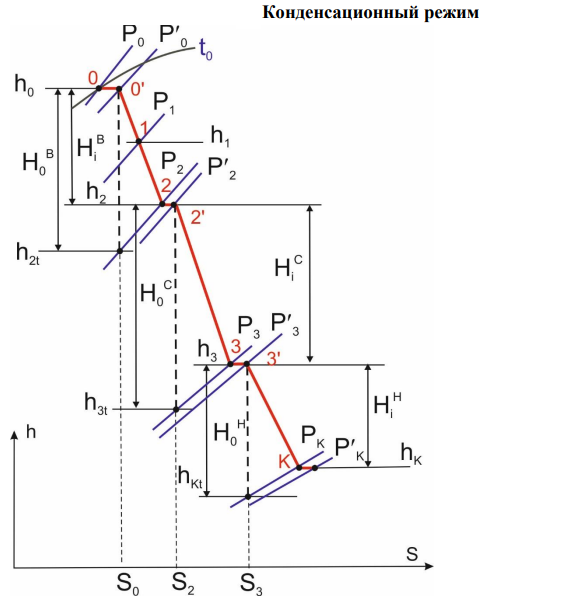

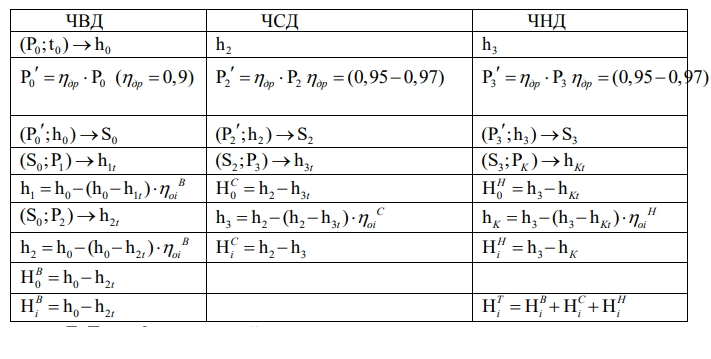

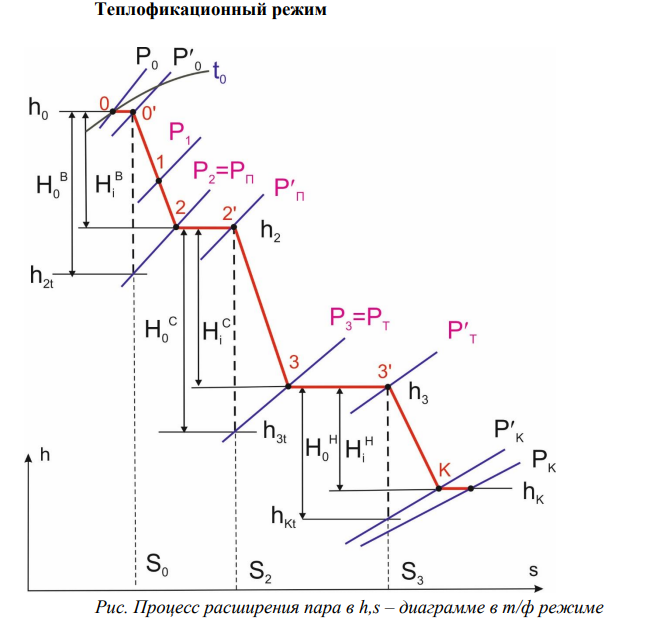


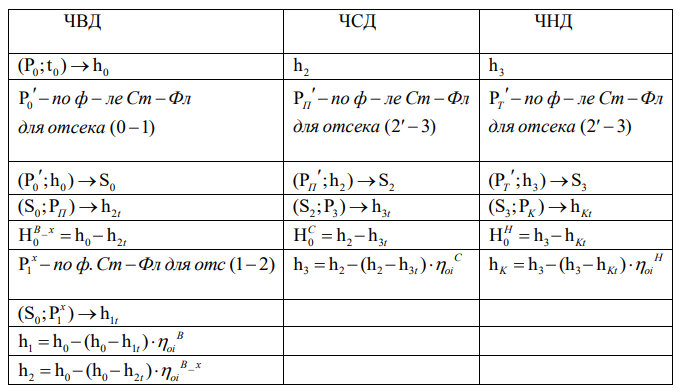

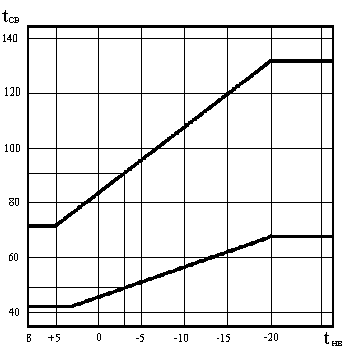